- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


https://yonghyuc.wordpress.com/2019/08/06/pytorch-cuda-gpu-%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0/

In [3]:
import torch
from torch import nn, optim
from sklearn.datasets import load_digits
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
if device == "cuda":
  torch.cuda.manual_seed_all(42)

## Load Data

In [16]:
digits=load_digits() ## 손글씨 데이터

In [18]:
input = digits.data
output = digits.target  # 각 이미지에 대응하는 숫자

In [25]:
input.shape ####(n_samples, n_features)

(1797, 64)

In [32]:
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [34]:
print(digits['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [30]:
output[0]

0

<Figure size 432x288 with 0 Axes>

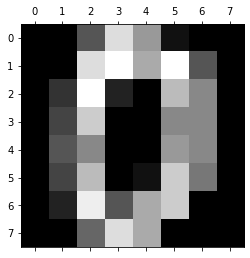

In [38]:
plt.gray() 
plt.matshow(digits.images[0]) 
plt.show()

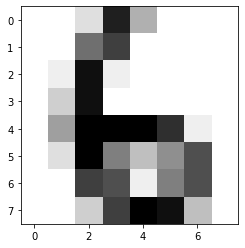

In [37]:
# imshow()는 행렬 형태의 2차원 데이터를 색깔로 표시해줌 
# 픽셀들의 축 위치 간격을 보정하여 이미지가 자연스러운 모양으로 보일 수 있게 하는 방법
# nearest는 가장 고해상도 보간법 
plt.imshow(digits.images[1005], cmap=plt.cm.gray_r, interpolation='nearest') 
plt.show()

In [35]:
print(digits.images.shape)
print(digits.data.shape)

(1797, 8, 8)
(1797, 64)


In [39]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= digits.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김 (device)
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [45]:
print(x_train[0], x_train[0].shape) #8*8
print(y_train[0],y_train[1])

#input 1797개 (len 64 array)
#y의 class는 10개 (0-9)

tensor([ 0.,  0.,  0., 16., 12.,  1.,  0.,  0.,  0.,  0.,  6., 16., 14.,  7.,
         0.,  0.,  0.,  0., 14., 15.,  1., 11.,  0.,  0.,  0.,  0., 16., 15.,
         0., 14.,  1.,  0.,  0.,  1., 16., 10.,  0., 14.,  2.,  0.,  0.,  0.,
        15., 13.,  3., 15.,  3.,  0.,  0.,  0.,  9., 16., 16., 15.,  0.,  0.,
         0.,  0.,  0., 13., 16.,  8.,  0.,  0.], device='cuda:0') torch.Size([64])
tensor(0, device='cuda:0') tensor(7, device='cuda:0')


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 **Dataset을 정의**하고, 이를 **DataLoader에 전달**하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [51]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [52]:
batch_size = 8
#Dataset을 정의
dataset = CustomDataset() # init 실행 -> 데이터셋의 전처리를 해주는 부분 전역변수인 x_train, y_train 가져옴 
#DataLoader에 전달
dataloader = DataLoader(dataset, batch_size=batch_size) 

# 모델링

## activation function

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

activation function 이용 파라미터가 필요 X (https://pytorch.org/docs/stable/nn.html)
- nn.ReLU()
- nn.tanH()


- batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
- 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용함
- 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

nn.Sigmoid()

In [56]:
class Model_sigmoid(torch.nn.Module):

  def __init__(self):
    super(Model_sigmoid, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,398, bias=True), # input_layer = 30, hidden_layer1 = 398 
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 10, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

nn.ReLU()

In [81]:

class Model_relu(torch.nn.Module):

  def __init__(self):
    super(Model_relu, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,398, bias=True), # input_layer = 30, hidden_layer1 = 398 
          nn.ReLU(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 10, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

nn.tanh()

In [84]:
class Model_tanh(torch.nn.Module):

  def __init__(self):
    super(Model_tanh, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,398, bias=True), # input_layer = 30, hidden_layer1 = 398 
          nn.Tanh(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Tanh()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Tanh()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 10, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

## weight initialize
Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

### xavier 
xavier 분포 사용 gradient explode/vanish 막는...?

In [77]:
def init_weights_xavier(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

### Normal distribution

In [78]:
def init_weights_Gaussian(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.normal_(layer.weight)
        layer.bias.data.fill_(0.01)


## 모델

In [85]:
model_s = Model_sigmoid().to(device)
model_r = Model_relu().to(device)
model_t = Model_tanh().to(device)


In [86]:
model_s.apply(init_weights_xavier)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model_sigmoid(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [87]:
model_r.apply(init_weights_xavier)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model_relu(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [88]:
model_t.apply(init_weights_xavier)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model_tanh(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=398, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

# Sigmoid +xavior + adam

In [89]:
model = model_s

## Optimizer 
이건 아직 어렵다

In [74]:
loss_fn  = nn.CrossEntropyLoss().to(device)

### optimizer -> Adam

In [90]:

optimizer_adam = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

### optimizer -> SGD 
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
sgd 등등

In [91]:
optimizer_sgd = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

### optimizer 고르기

In [92]:
optimizer = optimizer_adam 

## Train ?

In [94]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.5350135564804077
10 1.5156371593475342
20 1.5035064220428467
30 1.495517611503601
40 1.489952564239502
50 1.4858590364456177
60 1.482729434967041
70 1.4802625179290771
80 1.4782662391662598
90 1.4766145944595337


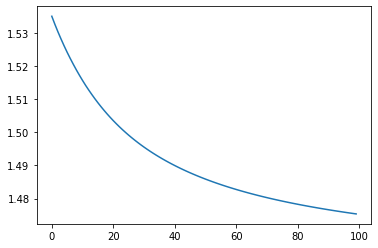

In [95]:
plt.plot(losses)
plt.show()

### Prediction

In [96]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [97]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [2.1958880e-03 9.7547340e-01 1.4592690e-03 6.2254900e-03 6.5607079e-03
 1.8241915e-05 2.8518436e-05 4.8615562e-04 3.2466630e-06 7.5489846e-03]
argmax를 한 후의 output은 1
accuracy는 0.9833333333333333


## ReLU + xavior + adam

In [98]:
model = model_r

In [99]:
loss_fn  = nn.CrossEntropyLoss().to(device)

In [100]:
optimizer_adam = optim.Adam(model.parameters(), lr= 0.01)

In [104]:
optimizer = optimizer_adam

In [106]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

RuntimeError: ignored

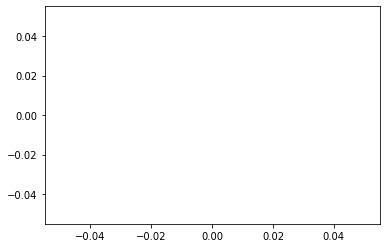

In [107]:
plt.plot(losses)
plt.show()

In [103]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')